# Waste Classification Project using a complete CNN from scratch with a pipeline of Preprocessing and Image Enhancement => Segmentation => Feature Extraction => Classification => Evaluation and Performance Metrics.

In [1]:
!python3 prepare_dataset.py

Preparing waste classification dataset from: /home/x/Desktop/cvv/dataset/
Found 3 classes: Boxes, Metal, Plastic
  Class Boxes: 500 images
  Class Metal: 500 images
  Class Plastic: 500 images

Dataset split complete:
  Training: 1050 images
  Validation: 225 images
  Test: 225 images
Dataset files written to ./labels


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.utils import shuffle
import time
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Pipeline
from utils import load_dataset, visualize_results, save_model, ModelEvaluator
from preprocessing import ImagePreprocessor
from feature_extraction import FeatureExtractor
from classification import CustomClassifier

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

np.random.seed(42)
tf.random.set_seed(42)

2025-05-07 05:06:52.377600: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 05:06:52.397135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746594412.419678  396471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746594412.426348  396471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746594412.443370  396471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
print("devices:", tf.config.list_physical_devices())
print("Is GPU available:", tf.config.list_physical_devices('GPU'))
print("Using CPU for computation")

print("Starting Waste Classification Project Pipeline:")
print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())}")

print("\n[1] Loading dataset...")
dataset_path = "/home/x/Desktop/cvv/dataset/"
dataset = load_dataset(dataset_path)

if dataset is None:
    print("Error loading dataset. Exiting.")
    raise ValueError("Dataset could not be loaded")

categories = dataset['categories']
print(f"Categories: {categories}")
print(f"Number of training samples: {len(dataset['train_data'])}")
print(f"Number of validation samples: {len(dataset['val_data'])}")
print(f"Number of test samples: {len(dataset['test_data'])}")

devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Is GPU available: []
Using CPU for computation
Starting Waste Classification Project Pipeline:
Current time: 2025-05-07 05:06:56

[1] Loading dataset...
Categories: ['Boxes', 'Metal', 'Plastic']
Number of training samples: 1050
Number of validation samples: 225
Number of test samples: 225


2025-05-07 05:06:56.405047: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training class distribution:
  Class Boxes: 350 samples (33.3%)
  Class Metal: 350 samples (33.3%)
  Class Plastic: 350 samples (33.3%)

Validation class distribution:
  Class Boxes: 75 samples (33.3%)
  Class Metal: 75 samples (33.3%)
  Class Plastic: 75 samples (33.3%)

Test class distribution:
  Class Boxes: 75 samples (33.3%)
  Class Metal: 75 samples (33.3%)
  Class Plastic: 75 samples (33.3%)

Final dataset sizes:
  Training: 1050 samples
  Validation: 225 samples
  Test: 225 samples


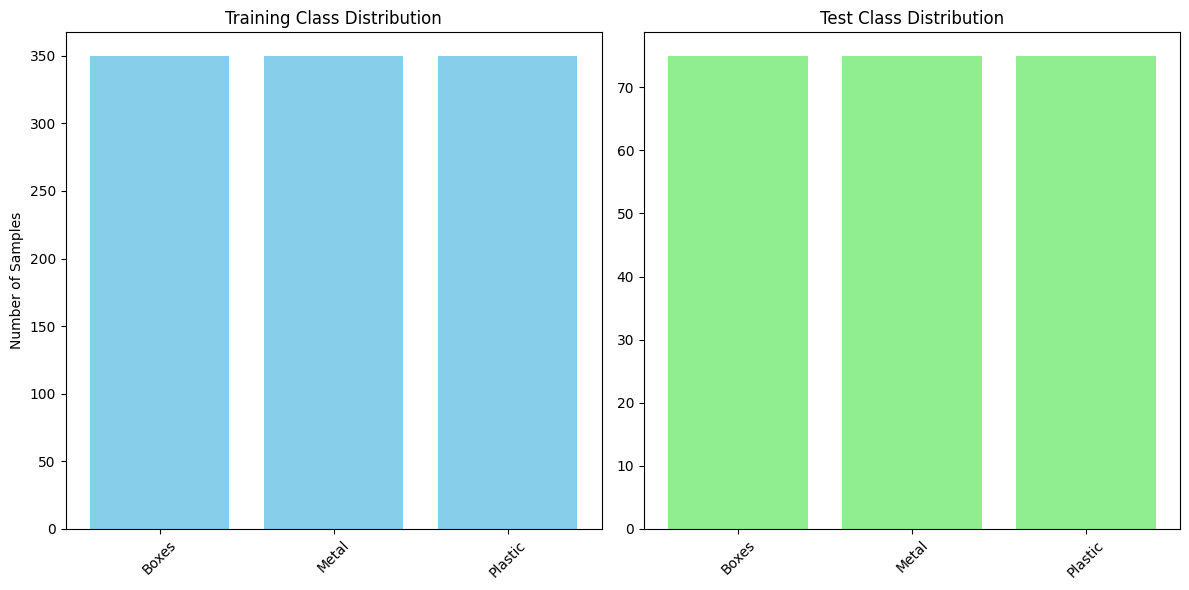


Starting preprocessing with material-specific augmentations...


In [4]:
def analyze_class_distribution(labels, name, categories):
    counts = np.zeros(len(categories), dtype=int)
    for label in labels:
        counts[label] += 1
    
    print(f"\n{name} class distribution:")
    for i, count in enumerate(counts):
        print(f"  Class {categories[i]}: {count} samples ({count/len(labels)*100:.1f}%)")
    return counts

train_counts = analyze_class_distribution(dataset['train_labels'], "Training", categories)
val_counts = analyze_class_distribution(dataset['val_labels'], "Validation", categories)
test_counts = analyze_class_distribution(dataset['test_labels'], "Test", categories)

train_data = dataset['train_data']
train_labels = dataset['train_labels']
val_data = dataset['val_data']
val_labels = dataset['val_labels']
test_data = dataset['test_data']
test_labels = dataset['test_labels']

print(f"\nFinal dataset sizes:")
print(f"  Training: {len(train_data)} samples")
print(f"  Validation: {len(val_data)} samples")
print(f"  Test: {len(test_data)} samples")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(categories, train_counts, color='skyblue')
plt.title('Training Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
plt.bar(categories, test_counts, color='lightgreen')
plt.title('Test Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nWarning: Processing the full dataset on CPU may take a significant amount of time.")
print("Starting preprocessing with material-specific augmentations...")


[2] Applying enhanced preprocessing...


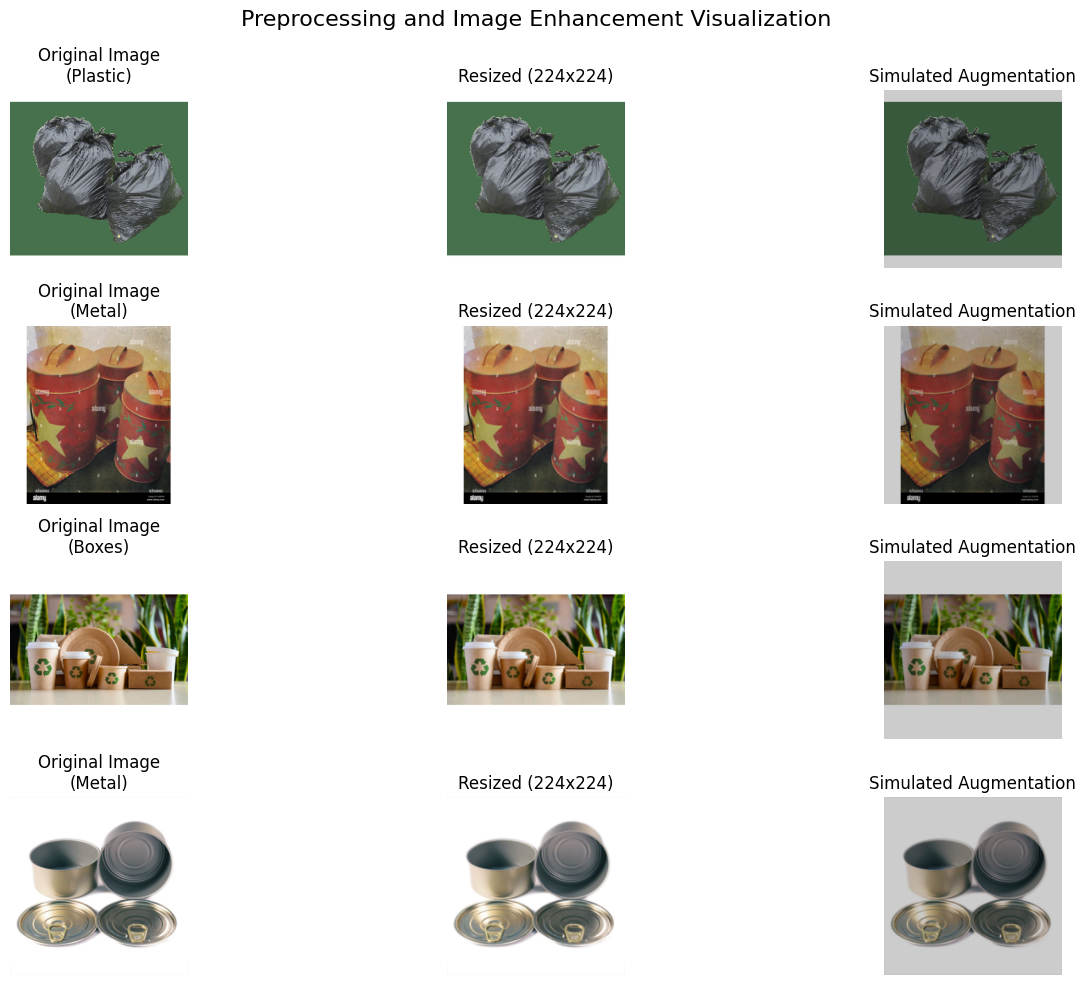

In [5]:
print("\n[2] Applying enhanced preprocessing...")

preprocessor = ImagePreprocessor(
    target_size=(224, 224), 
    apply_augmentation=True
)

batch_size = 1500

def process_in_batches(data_list, with_augmentation=False, desc="Processing"):
    preprocessor.apply_augmentation = with_augmentation
    all_processed = []
    
    for i in range(0, len(data_list), batch_size):
        batch_end = min(i + batch_size, len(data_list))
        batch = data_list[i:batch_end]
        
        print(f"Processing batch {i//batch_size + 1}/{(len(data_list)-1)//batch_size + 1} ({i}:{batch_end})")
        processed_batch = preprocessor.batch_preprocess(batch, segment=False)
        all_processed.extend(processed_batch)
        
        gc.collect()
    
    return all_processed

plt.figure(figsize=(15, 10))
plt.suptitle("Preprocessing and Image Enhancement Visualization", fontsize=16)

if len(train_data) > 0 and isinstance(train_data[0], str):
    num_examples = min(4, len(train_data))
    example_indices = np.random.choice(len(train_data), num_examples, replace=False)
    
    for i, idx in enumerate(example_indices):
        img_path = train_data[idx]
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(num_examples, 3, i*3+1)
                plt.imshow(img)
                plt.title(f"Original Image\n({categories[train_labels[idx]]})")
                plt.axis('off')
                
                resized = cv2.resize(img, (224, 224))
                plt.subplot(num_examples, 3, i*3+2)
                plt.imshow(resized)
                plt.title("Resized (224x224)")
                plt.axis('off')
                
                augmented = resized.copy()
                hsv = cv2.cvtColor(augmented, cv2.COLOR_RGB2HSV)
                hsv[:,:,2] = hsv[:,:,2] * 0.8
                augmented = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                
                plt.subplot(num_examples, 3, i*3+3)
                plt.imshow(augmented)
                plt.title("Simulated Augmentation")
                plt.axis('off')
        except Exception as e:
            print(f"Error processing visualization for image {img_path}: {str(e)}")
else:
    plt.text(0.5, 0.5, "Cannot visualize preprocessing - data not in expected format", 
             ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Processing batch 1/1 (0:1050)


Preprocessing images: 100%|████████████████| 1050/1050 [00:04<00:00, 232.09it/s]


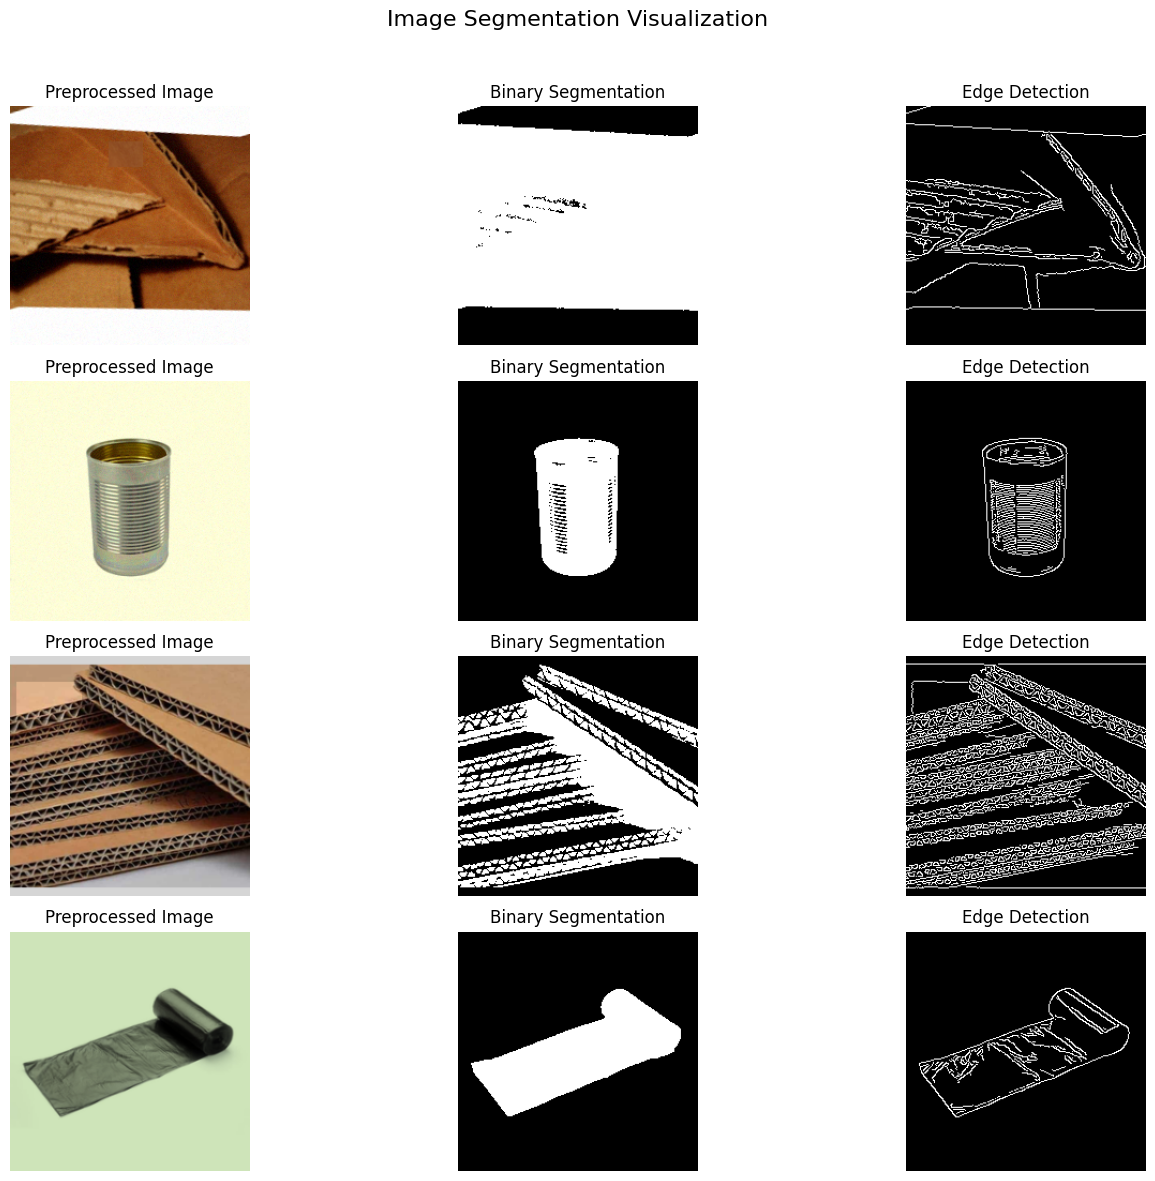

In [6]:
X_train_preprocessed = process_in_batches(train_data, with_augmentation=True, desc="Preprocessing training images")

if len(X_train_preprocessed) > 0:
    plt.figure(figsize=(15, 12))
    plt.suptitle("Image Segmentation Visualization", fontsize=16)
    
    num_examples = min(4, len(X_train_preprocessed))
    for i in range(num_examples):
        img = X_train_preprocessed[i]
        
        plt.subplot(num_examples, 3, i*3+1)
        plt.imshow(img)
        plt.title(f"Preprocessed Image")
        plt.axis('off')
        
        try:
            gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            plt.subplot(num_examples, 3, i*3+2)
            plt.imshow(thresh, cmap='gray')
            plt.title("Binary Segmentation")
            plt.axis('off')
            
            edges = cv2.Canny(gray, 50, 150)
            plt.subplot(num_examples, 3, i*3+3)
            plt.imshow(edges, cmap='gray')
            plt.title("Edge Detection")
            plt.axis('off')
        except Exception as e:
            print(f"Error in segmentation visualization: {e}")
            plt.subplot(num_examples, 3, i*3+2)
            plt.text(0.5, 0.5, "Segmentation error", ha='center', va='center')
            plt.axis('off')
            plt.subplot(num_examples, 3, i*3+3)
            plt.text(0.5, 0.5, "Edge detection error", ha='center', va='center')
            plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [7]:
X_val_preprocessed = process_in_batches(val_data, with_augmentation=False, desc="Preprocessing validation images")
X_test_preprocessed = process_in_batches(test_data, with_augmentation=False, desc="Preprocessing test images")

Processing batch 1/1 (0:225)


Preprocessing images: 100%|██████████████████| 225/225 [00:00<00:00, 504.26it/s]


Processing batch 1/1 (0:225)


Preprocessing images: 100%|██████████████████| 225/225 [00:00<00:00, 520.99it/s]


In [8]:
print("\n[3] Extracting features...")

feature_extractor = FeatureExtractor(input_shape=(224, 224, 3))

def extract_features_in_batches(images, batch_size=4, desc="Extracting features"):
    all_features = []
    
    for i in range(0, len(images), batch_size):
        batch_end = min(i + batch_size, len(images))
        batch = images[i:batch_end]
        
        print(f"Extracting features batch {i//batch_size + 1}/{(len(images)-1)//batch_size + 1} ({i}:{batch_end})")
        try:
            batch_features = feature_extractor.batch_extract_features(batch, batch_size=4)
            all_features.extend(batch_features)
        except Exception as e:
            print(f"Error in batch extraction: {e}")
            placeholder_features = [np.zeros(1500) for _ in range(len(batch))]
            all_features.extend(placeholder_features)
        
        gc.collect()
    
    return np.array(all_features)


[3] Extracting features...
Feature extractor initialized with output shape: (None, 1280)


Extracting features batch 1/263 (0:4)


Extracting features: 100%|████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Extracting features batch 2/263 (4:8)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


Extracting features batch 3/263 (8:12)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 4/263 (12:16)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 5/263 (16:20)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


Extracting features batch 6/263 (20:24)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


Extracting features batch 7/263 (24:28)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


Extracting features batch 8/263 (28:32)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


Extracting features batch 9/263 (32:36)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


Extracting features batch 10/263 (36:40)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.50it/s]


Extracting features batch 11/263 (40:44)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.56it/s]


Extracting features batch 12/263 (44:48)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


Extracting features batch 13/263 (48:52)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


Extracting features batch 14/263 (52:56)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 15/263 (56:60)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


Extracting features batch 16/263 (60:64)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Extracting features batch 17/263 (64:68)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 18/263 (68:72)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 19/263 (72:76)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


Extracting features batch 20/263 (76:80)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.75it/s]


Extracting features batch 21/263 (80:84)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


Extracting features batch 22/263 (84:88)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 23/263 (88:92)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 24/263 (92:96)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 25/263 (96:100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 26/263 (100:104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 27/263 (104:108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 28/263 (108:112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 29/263 (112:116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 30/263 (116:120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 31/263 (120:124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 32/263 (124:128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 33/263 (128:132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 34/263 (132:136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


Extracting features batch 35/263 (136:140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 36/263 (140:144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 37/263 (144:148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 38/263 (148:152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 39/263 (152:156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 40/263 (156:160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 41/263 (160:164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 42/263 (164:168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 43/263 (168:172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 44/263 (172:176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 45/263 (176:180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


Extracting features batch 46/263 (180:184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 47/263 (184:188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 48/263 (188:192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 49/263 (192:196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 50/263 (196:200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 51/263 (200:204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 52/263 (204:208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 53/263 (208:212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 54/263 (212:216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 55/263 (216:220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 56/263 (220:224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 57/263 (224:228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 58/263 (228:232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 59/263 (232:236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 60/263 (236:240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 61/263 (240:244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 62/263 (244:248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 63/263 (248:252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 64/263 (252:256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 65/263 (256:260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 66/263 (260:264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 67/263 (264:268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 68/263 (268:272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 69/263 (272:276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 70/263 (276:280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 71/263 (280:284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 72/263 (284:288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


Extracting features batch 73/263 (288:292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 74/263 (292:296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 75/263 (296:300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.66it/s]


Extracting features batch 76/263 (300:304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 77/263 (304:308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 78/263 (308:312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 79/263 (312:316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 80/263 (316:320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


Extracting features batch 81/263 (320:324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 82/263 (324:328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


Extracting features batch 83/263 (328:332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 84/263 (332:336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


Extracting features batch 85/263 (336:340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 86/263 (340:344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 87/263 (344:348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 88/263 (348:352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 89/263 (352:356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 90/263 (356:360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 91/263 (360:364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 92/263 (364:368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 93/263 (368:372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 94/263 (372:376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 95/263 (376:380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 96/263 (380:384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 97/263 (384:388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 98/263 (388:392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 99/263 (392:396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 100/263 (396:400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 101/263 (400:404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 102/263 (404:408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 103/263 (408:412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 104/263 (412:416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 105/263 (416:420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 106/263 (420:424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 107/263 (424:428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 108/263 (428:432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 109/263 (432:436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Extracting features batch 110/263 (436:440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 111/263 (440:444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 112/263 (444:448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 113/263 (448:452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 114/263 (452:456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 115/263 (456:460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 116/263 (460:464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 117/263 (464:468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Extracting features batch 118/263 (468:472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 119/263 (472:476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 120/263 (476:480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 121/263 (480:484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 122/263 (484:488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Extracting features batch 123/263 (488:492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 124/263 (492:496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 125/263 (496:500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 126/263 (500:504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 127/263 (504:508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 128/263 (508:512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 129/263 (512:516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 130/263 (516:520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 131/263 (520:524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 132/263 (524:528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 133/263 (528:532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 134/263 (532:536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


Extracting features batch 135/263 (536:540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


Extracting features batch 136/263 (540:544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


Extracting features batch 137/263 (544:548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


Extracting features batch 138/263 (548:552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 139/263 (552:556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 140/263 (556:560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


Extracting features batch 141/263 (560:564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 142/263 (564:568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 143/263 (568:572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 144/263 (572:576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 145/263 (576:580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 146/263 (580:584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 147/263 (584:588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 148/263 (588:592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 149/263 (592:596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 150/263 (596:600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 151/263 (600:604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 152/263 (604:608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 153/263 (608:612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 154/263 (612:616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 155/263 (616:620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 156/263 (620:624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 157/263 (624:628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 158/263 (628:632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 159/263 (632:636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 160/263 (636:640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 161/263 (640:644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 162/263 (644:648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 163/263 (648:652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 164/263 (652:656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


Extracting features batch 165/263 (656:660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 166/263 (660:664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 167/263 (664:668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 168/263 (668:672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Extracting features batch 169/263 (672:676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


Extracting features batch 170/263 (676:680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 171/263 (680:684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 172/263 (684:688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 173/263 (688:692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 174/263 (692:696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 175/263 (696:700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 176/263 (700:704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Extracting features batch 177/263 (704:708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 178/263 (708:712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 179/263 (712:716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 180/263 (716:720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 181/263 (720:724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 182/263 (724:728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 183/263 (728:732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 184/263 (732:736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 185/263 (736:740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 186/263 (740:744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 187/263 (744:748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 188/263 (748:752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 189/263 (752:756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 190/263 (756:760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 191/263 (760:764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 192/263 (764:768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 193/263 (768:772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 194/263 (772:776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 195/263 (776:780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 196/263 (780:784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 197/263 (784:788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 198/263 (788:792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 199/263 (792:796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 200/263 (796:800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 201/263 (800:804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 202/263 (804:808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 203/263 (808:812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 204/263 (812:816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 205/263 (816:820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 206/263 (820:824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 207/263 (824:828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 208/263 (828:832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 209/263 (832:836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 210/263 (836:840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 211/263 (840:844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 212/263 (844:848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 213/263 (848:852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 214/263 (852:856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 215/263 (856:860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 216/263 (860:864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


Extracting features batch 217/263 (864:868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 218/263 (868:872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 219/263 (872:876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 220/263 (876:880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 221/263 (880:884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 222/263 (884:888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 223/263 (888:892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 224/263 (892:896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 225/263 (896:900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 226/263 (900:904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 227/263 (904:908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 228/263 (908:912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 229/263 (912:916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 230/263 (916:920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 231/263 (920:924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 232/263 (924:928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 233/263 (928:932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 234/263 (932:936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 235/263 (936:940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 236/263 (940:944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 237/263 (944:948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 238/263 (948:952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 239/263 (952:956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 240/263 (956:960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 241/263 (960:964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 242/263 (964:968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 243/263 (968:972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 244/263 (972:976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 245/263 (976:980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 246/263 (980:984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 247/263 (984:988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 248/263 (988:992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 249/263 (992:996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 250/263 (996:1000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 251/263 (1000:1004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 252/263 (1004:1008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 253/263 (1008:1012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 254/263 (1012:1016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


Extracting features batch 255/263 (1016:1020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 256/263 (1020:1024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 257/263 (1024:1028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 258/263 (1028:1032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.75it/s]


Extracting features batch 259/263 (1032:1036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


Extracting features batch 260/263 (1036:1040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


Extracting features batch 261/263 (1040:1044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 262/263 (1044:1048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 263/263 (1048:1050)


Extracting features: 100%|████████████████████████| 2/2 [00:00<00:00,  7.02it/s]


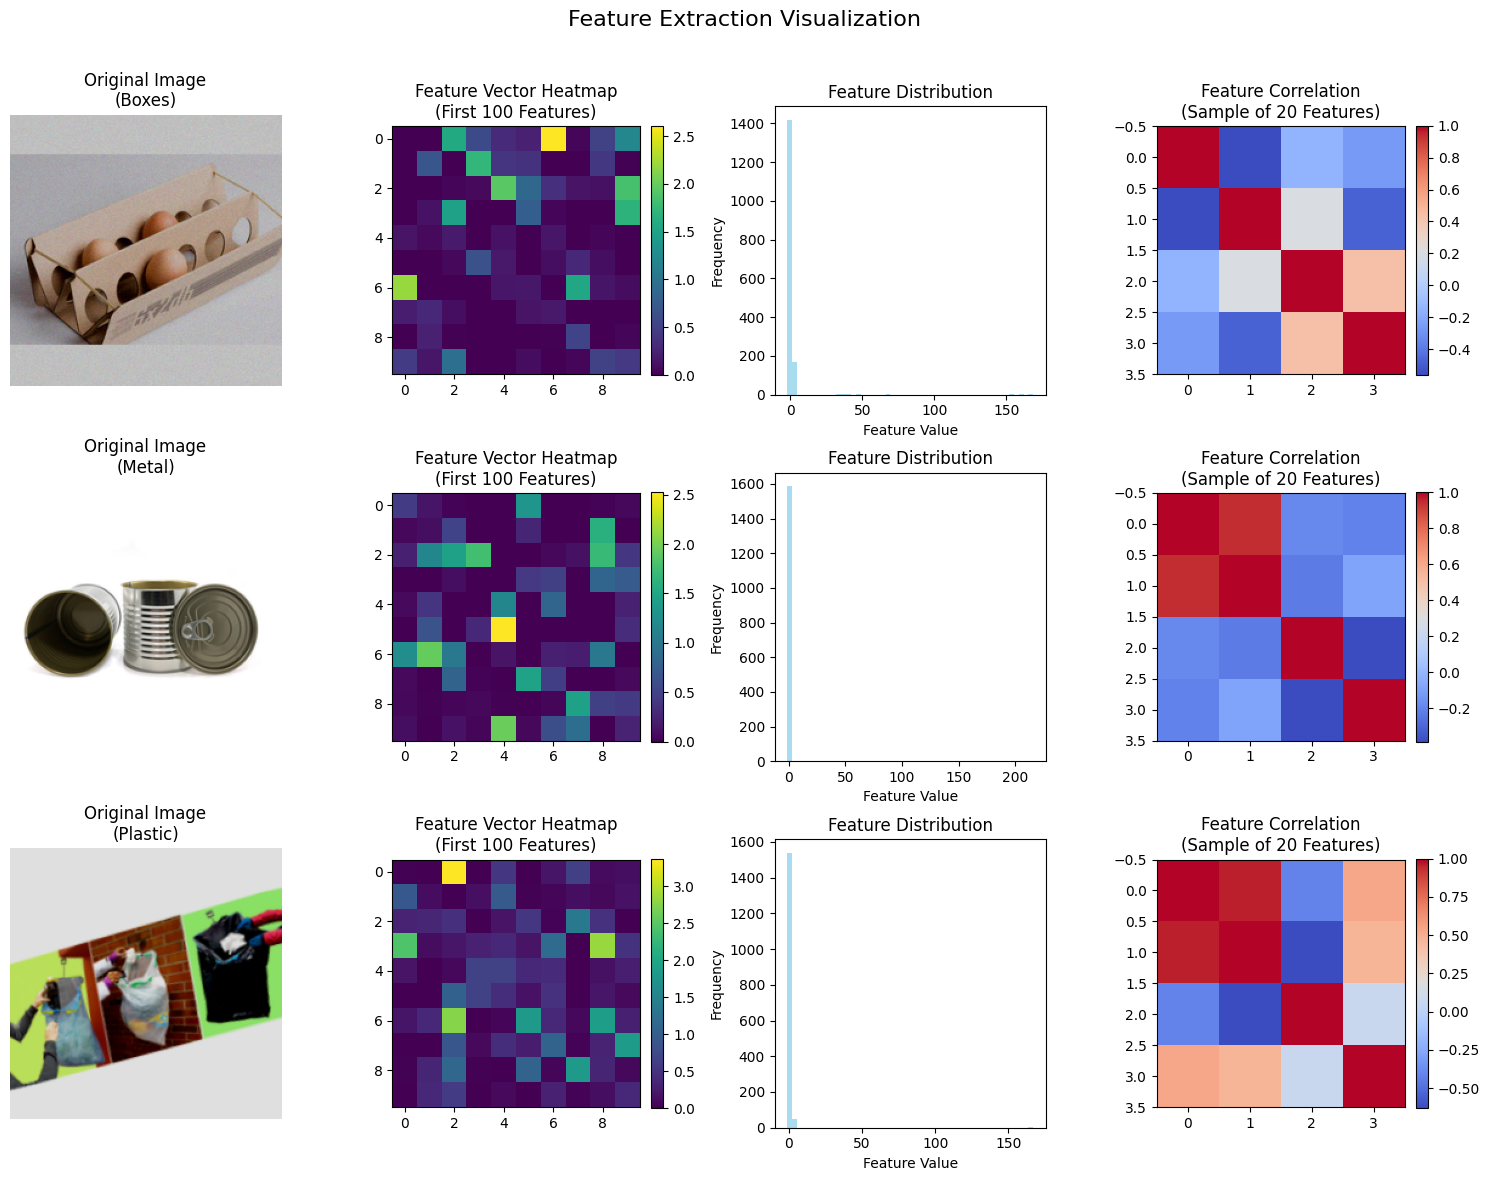

In [9]:
X_train_features = extract_features_in_batches(X_train_preprocessed, batch_size=4)

plt.figure(figsize=(15, 12))
plt.suptitle("Feature Extraction Visualization", fontsize=16)

num_examples = min(3, len(X_train_preprocessed))
example_indices = np.random.choice(len(X_train_preprocessed), num_examples, replace=False)

for i, idx in enumerate(example_indices):
    img = X_train_preprocessed[idx]
    features = X_train_features[idx]
    
    plt.subplot(num_examples, 4, i*4+1)
    plt.imshow(img)
    plt.title(f"Original Image\n({categories[train_labels[idx]]})")
    plt.axis('off')
    
    plt.subplot(num_examples, 4, i*4+2)
    features_display = features[:100].reshape(10, 10)
    plt.imshow(features_display, cmap='viridis')
    plt.title("Feature Vector Heatmap\n(First 100 Features)")
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(num_examples, 4, i*4+3)
    plt.hist(features, bins=50, color='skyblue', alpha=0.7)
    plt.title("Feature Distribution")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    
    plt.subplot(num_examples, 4, i*4+4)
    sample_features = features[:20].reshape(4, 5)
    plt.imshow(np.corrcoef(sample_features), cmap='coolwarm')
    plt.title("Feature Correlation\n(Sample of 20 Features)")
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [10]:
X_val_features = extract_features_in_batches(X_val_preprocessed, batch_size=4)
X_test_features = extract_features_in_batches(X_test_preprocessed, batch_size=4)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(f"Training features shape: {X_train_features.shape}")
print(f"Validation features shape: {X_val_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

Extracting features batch 1/57 (0:4)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


Extracting features batch 2/57 (4:8)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.66it/s]


Extracting features batch 3/57 (8:12)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


Extracting features batch 4/57 (12:16)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 5/57 (16:20)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


Extracting features batch 6/57 (20:24)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 7/57 (24:28)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.75it/s]


Extracting features batch 8/57 (28:32)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


Extracting features batch 9/57 (32:36)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


Extracting features batch 10/57 (36:40)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


Extracting features batch 11/57 (40:44)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


Extracting features batch 12/57 (44:48)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


Extracting features batch 13/57 (48:52)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 14/57 (52:56)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 15/57 (56:60)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 16/57 (60:64)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 17/57 (64:68)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 18/57 (68:72)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 19/57 (72:76)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 20/57 (76:80)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


Extracting features batch 21/57 (80:84)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


Extracting features batch 22/57 (84:88)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


Extracting features batch 23/57 (88:92)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 24/57 (92:96)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 25/57 (96:100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 26/57 (100:104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 27/57 (104:108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 28/57 (108:112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 29/57 (112:116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 30/57 (116:120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 31/57 (120:124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 32/57 (124:128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 33/57 (128:132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 34/57 (132:136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 35/57 (136:140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 36/57 (140:144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 37/57 (144:148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 38/57 (148:152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 39/57 (152:156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 40/57 (156:160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 41/57 (160:164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 42/57 (164:168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 43/57 (168:172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 44/57 (172:176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 45/57 (176:180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 46/57 (180:184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 47/57 (184:188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 48/57 (188:192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 49/57 (192:196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 50/57 (196:200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 51/57 (200:204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 52/57 (204:208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 53/57 (208:212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 54/57 (212:216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


Extracting features batch 55/57 (216:220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 56/57 (220:224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 57/57 (224:225)


Extracting features: 100%|████████████████████████| 1/1 [00:00<00:00,  7.01it/s]


Extracting features batch 1/57 (0:4)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 2/57 (4:8)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 3/57 (8:12)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 4/57 (12:16)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Extracting features batch 5/57 (16:20)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 6/57 (20:24)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 7/57 (24:28)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


Extracting features batch 8/57 (28:32)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 9/57 (32:36)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 10/57 (36:40)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 11/57 (40:44)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 12/57 (44:48)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 13/57 (48:52)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 14/57 (52:56)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 15/57 (56:60)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 16/57 (60:64)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


Extracting features batch 17/57 (64:68)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 18/57 (68:72)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Extracting features batch 19/57 (72:76)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 20/57 (76:80)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 21/57 (80:84)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 22/57 (84:88)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 23/57 (88:92)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 24/57 (92:96)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 25/57 (96:100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 26/57 (100:104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 27/57 (104:108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 28/57 (108:112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 29/57 (112:116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 30/57 (116:120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 31/57 (120:124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 32/57 (124:128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 33/57 (128:132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 34/57 (132:136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 35/57 (136:140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 36/57 (140:144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 37/57 (144:148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 38/57 (148:152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 39/57 (152:156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 40/57 (156:160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 41/57 (160:164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 42/57 (164:168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 43/57 (168:172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 44/57 (172:176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 45/57 (176:180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 46/57 (180:184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 47/57 (184:188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 48/57 (188:192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 49/57 (192:196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 50/57 (196:200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 51/57 (200:204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 52/57 (204:208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 53/57 (208:212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 54/57 (212:216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 55/57 (216:220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 56/57 (220:224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 57/57 (224:225)


Extracting features: 100%|████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Training features shape: (1050, 1598)
Validation features shape: (225, 1598)
Test features shape: (225, 1598)



[4] Applying feature preprocessing...
Processed feature shapes:
  Training: (1050, 1598)
  Validation: (225, 1598)
  Test: (225, 1598)


/home/x/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


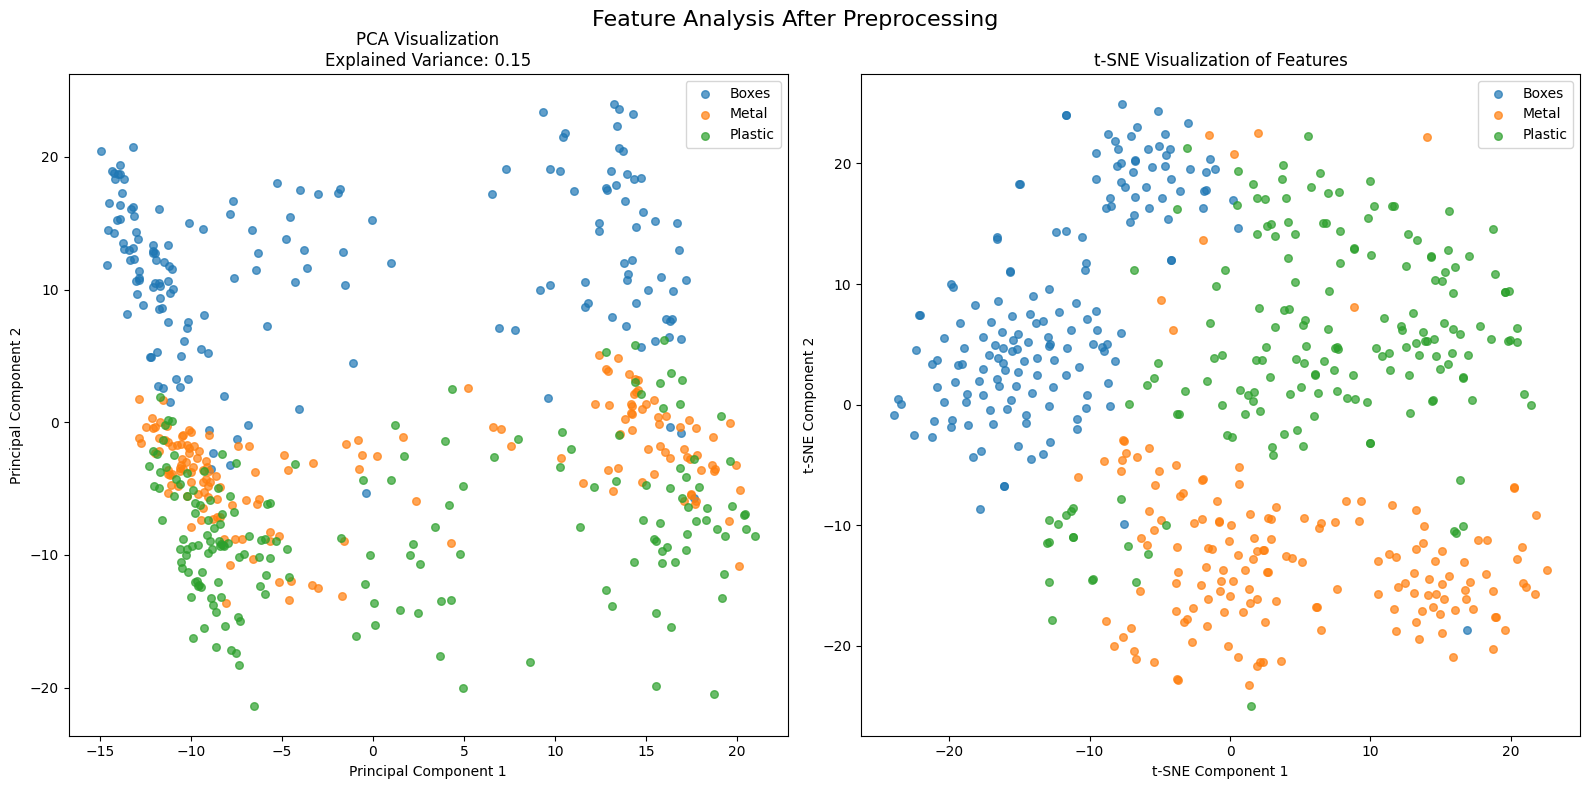

In [31]:
print("\n[4] Applying feature preprocessing...")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_train_features = np.nan_to_num(X_train_features)
X_val_features = np.nan_to_num(X_val_features)
X_test_features = np.nan_to_num(X_test_features)

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_features)
X_val_processed = scaler.transform(X_val_features)
X_test_processed = scaler.transform(X_test_features)

print(f"Processed feature shapes:")
print(f"  Training: {X_train_processed.shape}")
print(f"  Validation: {X_val_processed.shape}")
print(f"  Test: {X_test_processed.shape}")

plt.figure(figsize=(16, 8))
plt.suptitle("Feature Analysis After Preprocessing", fontsize=16)

sample_size = min(500, len(X_train_processed))
indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
X_sample = X_train_processed[indices]
y_sample = train_labels[indices]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

try:
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_sample)
    
    plt.subplot(1, 2, 1)
    for i, category in enumerate(categories):
        plt.scatter(X_pca[y_sample == i, 0], X_pca[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title(f"PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, category in enumerate(categories):
        plt.scatter(X_tsne[y_sample == i, 0], X_tsne[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title("t-SNE Visualization of Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
except Exception as e:
    print(f"Could not compute t-SNE: {e}")
    
    plt.subplot(1, 1, 1)
    for i, category in enumerate(categories):
        plt.scatter(X_pca[y_sample == i, 0], X_pca[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title(f"PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [32]:
print("\n[5] Training model with anti-overfitting measures...")

class_counts = np.bincount(train_labels)
total_samples = len(train_labels)

class_weights = {}
for i in range(len(categories)):
    if i in class_counts and class_counts[i] > 0:
        class_weights[i] = total_samples / (len(categories) * class_counts[i])
    else:
        class_weights[i] = 1.0

print(f"Class weights: {class_weights}")

classifier = CustomClassifier(
    input_shape=X_train_processed.shape[1],
    num_classes=len(categories),
    learning_rate=0.0005,
    dropout_rate=0.6,
    l2_reg=0.02
)


max_samples = min(4000, len(X_train_processed))


[5] Training model with anti-overfitting measures...
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}
Building model for input shape: 1598 with 3 classes


/home/x/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       204,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,611 (877.39 KB)

 Trainable params: 224,035 (875.14 KB)

 Non-trainable params: 576 (2.25 KB)

Training shapes: (1050, 1598) (1050,)
Validation shapes: (225, 1598) (225,)
Class distribution in training set:
  Class 0: 350 samples
  Class 1: 350 samples
  Class 2: 350 samples
Epoch 1/30
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3522 - loss: 15.6327

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3650 - loss: 15.4230 - val_accuracy: 0.7822 - val_loss: 13.6800 - learning_rate: 5.0000e-04
Epoch 2/30
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4931 - loss: 13.9830 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4952 - loss: 13.7948 - val_accuracy: 0.9244 - val_loss: 12.1761 - learning_rate: 5.0000e-04
Epoch 3/30
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5932 - loss: 12.3992 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5976 - loss: 12.2462 - val_accuracy: 0.9467 - val_loss: 10.8401 - learning_rate: 5.0000e-04
Epoch 4/30
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6739 - loss: 11.0911 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6802 - loss: 10.9198 - val_accuracy: 0.9556 - val_loss: 9.6254 - learning_rate: 5.0000e-04
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7995 - loss: 9.6602 - val_accuracy: 0.9556 - val_loss: 8.5189 - learning_rate: 5.0000e-04
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8049 - loss: 8.5483 - val_accuracy: 0.9556 - val_loss: 7.5207 - learning_rate: 5.0000e-04
Epoch 7/30
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8566 - loss: 7.6324 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8589 - loss: 7.4995 - val_accuracy: 0.9689 - val_loss: 6.6352 - learning_rate: 5.0000e-04
Epoch 8/30
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8696 - loss: 6.7210 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8748 - loss: 6.6162 - val_accuracy: 0.9733 - val_loss: 5.8429 - learning_rate: 5.0000e-04
Epoch 9/30
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8993 - loss: 5.8830 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9027 - loss: 5.7952 - val_accuracy: 0.9778 - val_loss: 5.1496 - learning_rate: 5.0000e-04
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9236 - loss: 5.0846 - val_accuracy: 0.9733 - val_loss: 4.5489 - learning_rate: 5.0000e-04
Epoch 11/30
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9407 - loss: 4.4769

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9406 - loss: 4.4635 - val_accuracy: 0.9822 - val_loss: 4.0214 - learning_rate: 5.0000e-04
Epoch 12/30
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9321 - loss: 3.9787 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9356 - loss: 3.9316 - val_accuracy: 0.9867 - val_loss: 3.5476 - learning_rate: 5.0000e-04
Epoch 13/30
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9524 - loss: 3.5229 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9510 - loss: 3.4685 - val_accuracy: 0.9911 - val_loss: 3.1519 - learning_rate: 5.0000e-04
Epoch 14/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9643 - loss: 3.0307 - val_accuracy: 0.9867 - val_loss: 2.8220 - learning_rate: 5.0000e-04
Epoch 15/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9753 - loss: 2.6655 - val_accuracy: 0.9822 - val_loss: 2.5356 - learning_rate: 5.0000e-04
Epoch 16/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9663 - loss: 2.3900 - val_accuracy: 0.9733 - val_loss: 2.2783 - learning_rate: 5.0000e-04
Epoch 17/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9789 - loss: 2.0949 - val_accuracy: 0.9778 - val_loss: 2.0556 - learning_rate: 5.0000e-04
Epoch 18/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9821 - loss: 1.9084 - val_accuracy: 0.9778 - val_loss: 1.9323 - learning_rate: 2.5000e-04
Epoch 19/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9797 - los

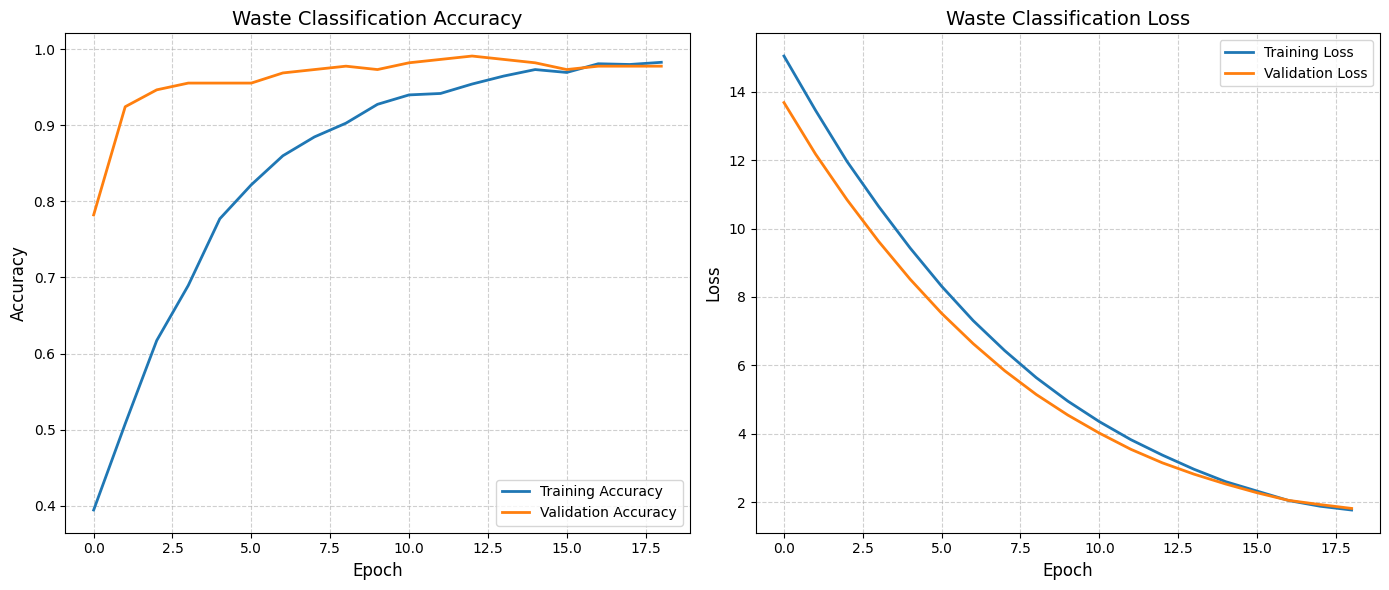

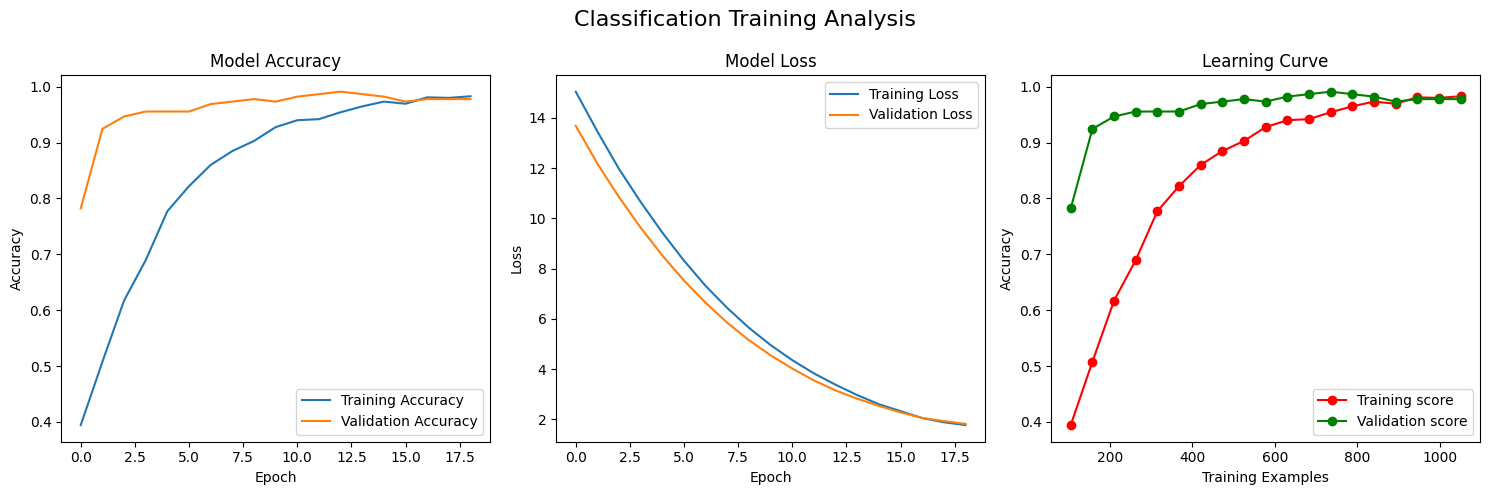

In [33]:
history = classifier.train(
    X_train=X_train_processed,
    y_train=train_labels,
    X_val=X_val_processed,
    y_val=val_labels,
    batch_size=64,
    epochs=30,
    patience=8,
    class_weights=class_weights,
    max_samples=max_samples
)

classifier.plot_training_history(history)

plt.figure(figsize=(15, 5))
plt.suptitle("Classification Training Analysis", fontsize=16)

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)

epochs = list(range(1, len(history.history['accuracy']) + 1))
train_sizes = np.linspace(0.1, 1.0, len(epochs)) * max_samples
plt.plot(train_sizes, history.history['accuracy'], 'o-', color='r', label="Training score")
plt.plot(train_sizes, history.history['val_accuracy'], 'o-', color='g', label="Validation score")
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc="best")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


[6] Evaluating model...
Prediction distribution:
  Class Boxes: 76 predictions (33.8%)
  Class Metal: 81 predictions (36.0%)
  Class Plastic: 68 predictions (30.2%)

===== Test Set Metrics =====
Accuracy: 0.9600
Precision: 0.9622
Recall: 0.9600
F1 Score: 0.9598

Classification Report:
              precision    recall  f1-score   support

       Boxes       0.96      0.97      0.97        75
       Metal       0.93      1.00      0.96        75
     Plastic       1.00      0.91      0.95        75

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225


Confusion Matrix:
[[73  2  0]
 [ 0 75  0]
 [ 3  4 68]]


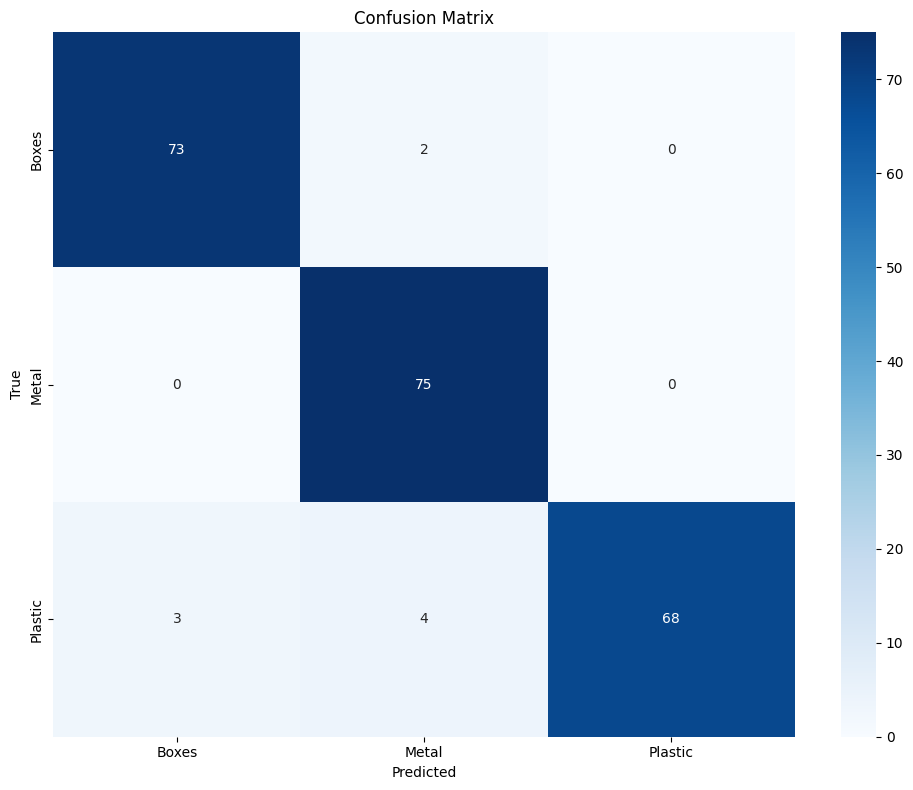

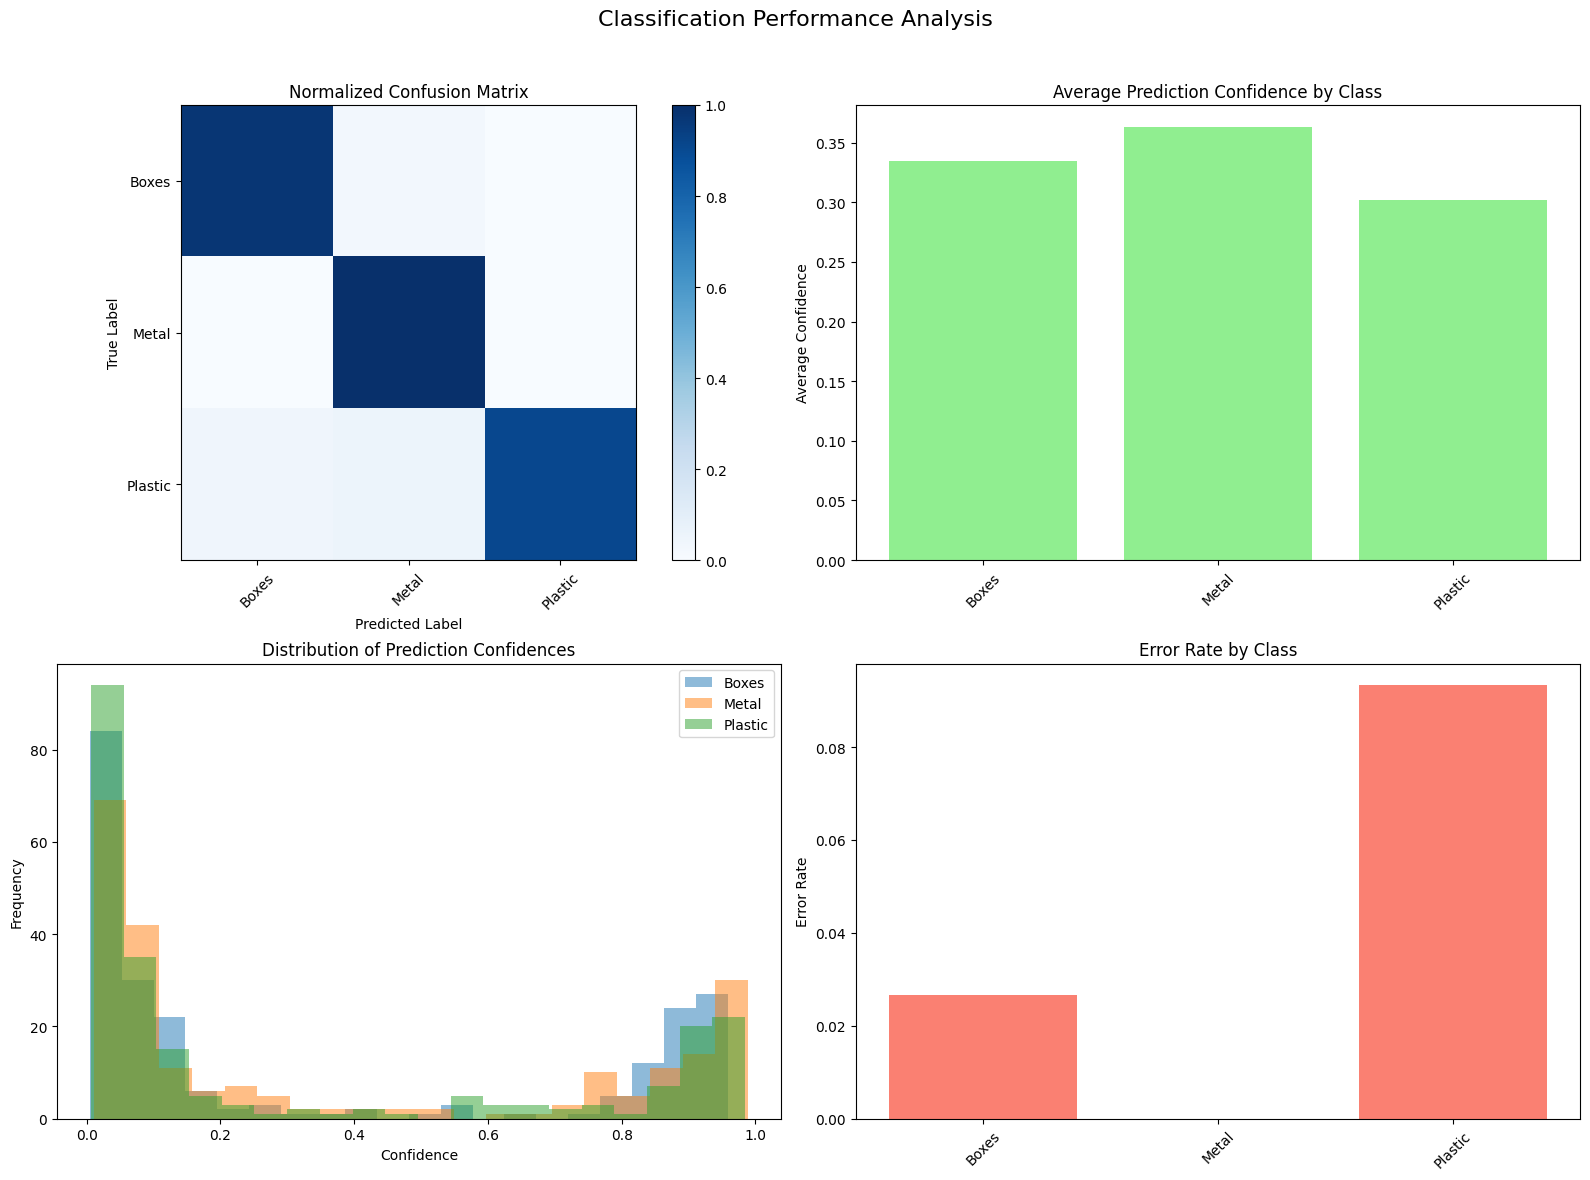

In [34]:
print("\n[6] Evaluating model...")
evaluator = ModelEvaluator(categories)

y_pred = classifier.predict(X_test_processed)

probabilities = classifier.model.predict(X_test_processed, verbose=0)

unique_preds, pred_counts = np.unique(y_pred, return_counts=True)
print(f"Prediction distribution:")
for pred_class in unique_preds:
    count = pred_counts[pred_class]
    print(f"  Class {categories[pred_class]}: {count} predictions ({count/len(y_pred)*100:.1f}%)")

evaluator.print_metrics(test_labels, y_pred, dataset_name="Test")

print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, y_pred)
print(cm)

try:
    evaluator.plot_confusion_matrix(test_labels, y_pred)
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

plt.figure(figsize=(16, 12))
plt.suptitle("Classification Performance Analysis", fontsize=16)

plt.subplot(2, 2, 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 2, 2)
prediction_dist = {}
for i, cat in enumerate(categories):
    prediction_dist[cat] = sum(probabilities[:, i]) / len(probabilities)

plt.bar(prediction_dist.keys(), prediction_dist.values(), color='lightgreen')
plt.title('Average Prediction Confidence by Class')
plt.xticks(rotation=45)
plt.ylabel('Average Confidence')

plt.subplot(2, 2, 3)
for i, cat in enumerate(categories):
    plt.hist(probabilities[:, i], alpha=0.5, bins=20, label=cat)
plt.title('Distribution of Prediction Confidences')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)

error_rates = []
for i in range(len(categories)):
    indices = np.where(test_labels == i)[0]
    if len(indices) > 0:
        error_rate = sum(y_pred[indices] != i) / len(indices)
        error_rates.append(error_rate)
    else:
        error_rates.append(0)

plt.bar(categories, error_rates, color='salmon')
plt.title('Error Rate by Class')
plt.xticks(rotation=45)
plt.ylabel('Error Rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


[7] Class-specific analysis...

Detailed metrics by class:
  Boxes:
    Precision: 0.9605
    Recall: 0.9733
    F1-score: 0.9669
    Support: 75.0 samples
  Metal:
    Precision: 0.9259
    Recall: 1.0000
    F1-score: 0.9615
    Support: 75.0 samples
  Plastic:
    Precision: 1.0000
    Recall: 0.9067
    F1-score: 0.9510
    Support: 75.0 samples


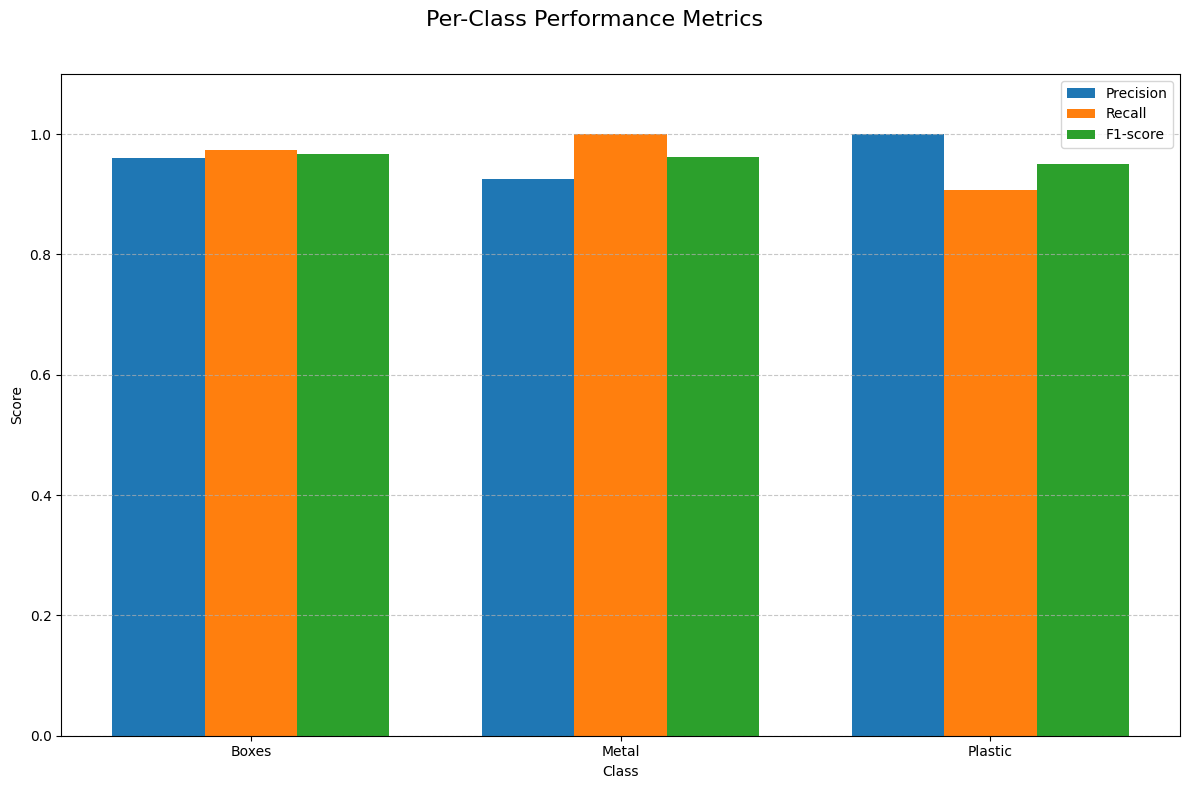

In [35]:
print("\n[7] Class-specific analysis...")

class_report = classification_report(test_labels, y_pred, target_names=categories, output_dict=True)

print("\nDetailed metrics by class:")
for material in categories:
    metrics = class_report[material]
    print(f"  {material.capitalize()}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1-score: {metrics['f1-score']:.4f}")
    print(f"    Support: {metrics['support']} samples")

plt.figure(figsize=(12, 8))
plt.suptitle("Per-Class Performance Metrics", fontsize=16)

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(categories))
width = 0.25

for i, metric in enumerate(metrics):
    values = [class_report[cat][metric] for cat in categories]
    plt.bar(x + i*width, values, width, label=metric.capitalize())

plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(x + width, categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


[8] Analyzing most confidently classified examples...
Most confidently classified examples:
  Image 77: True=Plastic, Predicted=Plastic, Confidence=98.1%
  Image 182: True=Metal, Predicted=Metal, Confidence=98.2%
  Image 130: True=Plastic, Predicted=Plastic, Confidence=98.5%
  Image 115: True=Metal, Predicted=Metal, Confidence=98.5%
  Image 160: True=Metal, Predicted=Metal, Confidence=98.9%


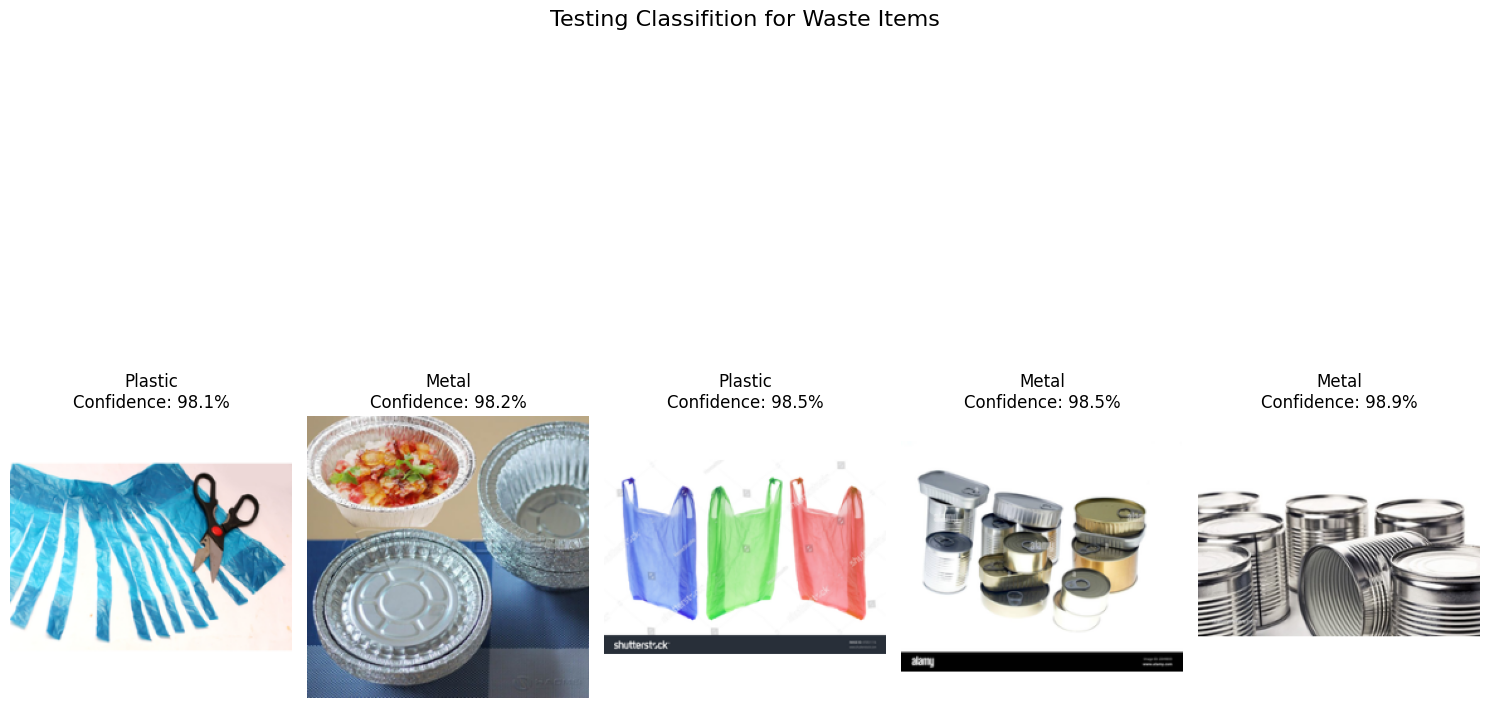

In [39]:
print("\n[8] Analyzing most confidently classified examples...")

correct_indices = np.where(y_pred == test_labels)[0]

num_examples = min(5, len(correct_indices))

if len(correct_indices) > 0:
    confidences = np.max(probabilities[correct_indices], axis=1)
    most_confident_correct = correct_indices[np.argsort(confidences)[-num_examples:]]
    
    print("Most confidently classified examples:")
    test_samples = []
    for idx in most_confident_correct:
        img = cv2.imread(test_data[idx])
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_samples.append(img)
        
        true_label = categories[test_labels[idx]]
        pred_label = categories[y_pred[idx]]
        confidence = np.max(probabilities[idx]) * 100
        print(f"  Image {idx}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.1f}%")
    
    plt.figure(figsize=(15, 10))
    plt.suptitle("Testing Classifition for Waste Items", fontsize=16)
    
    for i, img in enumerate(test_samples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(img)
        true_label = categories[test_labels[most_confident_correct[i]]]
        conf = np.max(probabilities[most_confident_correct[i]]) * 100
        plt.title(f"{true_label}\nConfidence: {conf:.1f}%")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [40]:
print("\n[9] Saving model...")
save_model(classifier.model, "waste_classifier_model.h5")
print("Model saved to waste_classifier_model.h5")

print("\nWaste Classification Pipeline completed successfully!")


[9] Saving model...
Model saved to waste_classifier_model.h5
Model saved to waste_classifier_model.h5

Waste Classification Pipeline completed successfully!


Boxes: Image_193.png
Metal: Image_72_1.png
Plastic: Image_41_1.png


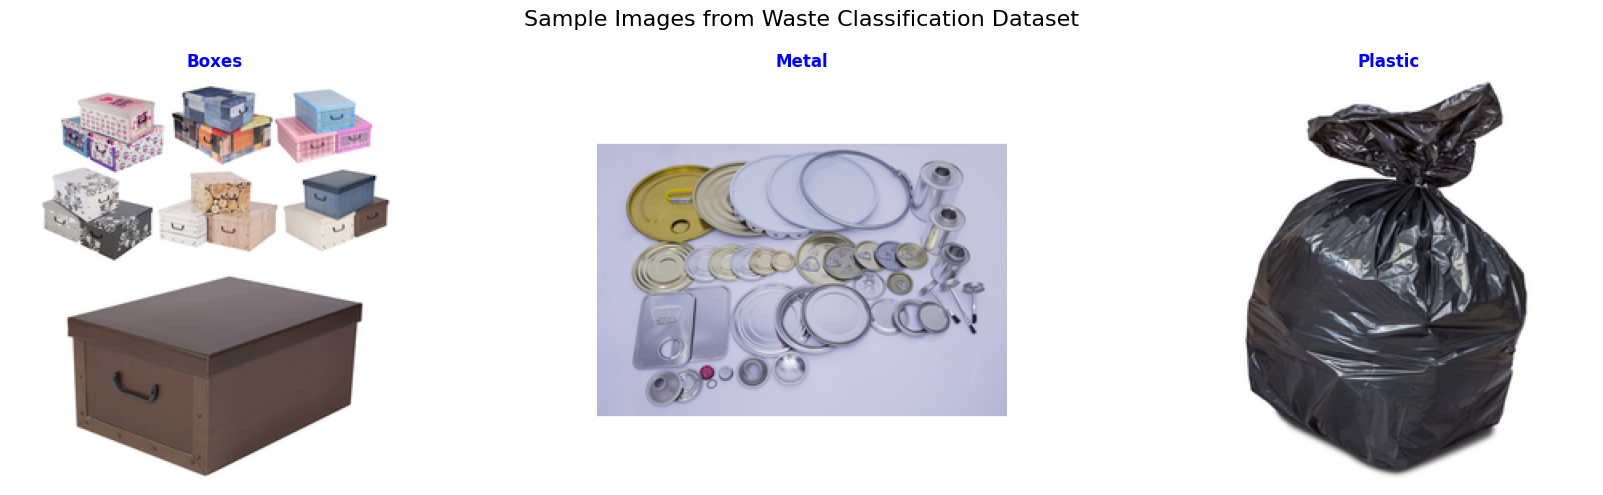

In [42]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

dataset_dir = '/home/x/Desktop/cvv/dataset'
categories = ['Boxes', 'Metal', 'Plastic']
main_categories = ['Boxes', 'Metal', 'Plastic']

def get_random_image(category):
    category_path = os.path.join(dataset_dir, 'classes', category)
    
    if not os.path.exists(category_path):
        print(f"Category path not found: {category_path}")
        return None

    try:
        all_images = [file for file in os.listdir(category_path) 
                      if file.lower().endswith(('.png', '.jpg', '.jpeg')) 
                      and os.path.isfile(os.path.join(category_path, file))]
        
        if not all_images:
            print(f"No images found in {category_path}")
            return None
        
        random_image = random.choice(all_images)
        img_path = os.path.join(category_path, random_image)
        
        print(f"{category}: {random_image}")
        
        return img_path
    except Exception as e:
        print(f"Error accessing {category_path}: {e}")
        return None

fig, axes = plt.subplots(1, len(categories), figsize=(18, 5))

for i, category in enumerate(categories):
    img_path = get_random_image(category)
    
    if img_path:
        try:
            img = Image.open(img_path)
            
            if img.mode == 'RGBA':
                img = img.convert('RGB')
                
            axes[i].imshow(img)
            
            title_color = 'black'
            if category in main_categories:
                title_color = 'blue'
                for spine in axes[i].spines.values():
                    spine.set_edgecolor('blue')
                    spine.set_linewidth(3)
            
            axes[i].set_title(category, color=title_color, fontweight='bold')
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error: {str(e)[:20]}...", 
                         ha='center', va='center', transform=axes[i].transAxes)
    else:
        axes[i].text(0.5, 0.5, f"No image found\nfor {category}", 
                     ha='center', va='center', transform=axes[i].transAxes)
    
    axes[i].axis('off')

plt.suptitle("Sample Images from Waste Classification Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [43]:
import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from feature_extraction import FeatureExtractor

os.makedirs("exported_models", exist_ok=True)

feature_extractor = FeatureExtractor(input_shape=(224, 224, 3))
base_model = feature_extractor.model

base_model.save("exported_models/feature_extractor_base_model.h5")
print("Saved feature extractor base model to exported_models/feature_extractor_base_model.h5")

print("Generating sample features to calibrate the scaler...")
sample_features = []

for _ in range(20):
    dummy_img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    
    try:
        features = feature_extractor.extract_features(dummy_img)
        features = np.nan_to_num(features)  # Replace NaN values
        sample_features.append(features)
    except Exception as e:
        print(f"Error extracting features: {e}")

if sample_features:
    sample_features = np.array(sample_features)
    print(f"Generated {len(sample_features)} sample feature vectors with shape {sample_features.shape}")
    
    scaler = StandardScaler()
    scaler.fit(sample_features)
    
    with open("exported_models/feature_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("Saved feature scaler to exported_models/feature_scaler.pkl")

feature_config = {
    "input_shape": (224, 224, 3),
    "feature_dimensions": sample_features.shape[1] if len(sample_features) > 0 else None,
    "use_deep_features": True,
    "use_color_features": True,
    "use_texture_features": True,
    "use_material_features": True
}

with open("exported_models/feature_config.pkl", "wb") as f:
    pickle.dump(feature_config, f)
print("Saved feature extraction configuration to exported_models/feature_config.pkl")

print("\nExported all components needed for the GUI to accurately replicate the feature extraction pipeline!")

Feature extractor initialized with output shape: (None, 1280)
Saved feature extractor base model to exported_models/feature_extractor_base_model.h5
Generating sample features to calibrate the scaler...
Generated 20 sample feature vectors with shape (20, 1598)
Saved feature scaler to exported_models/feature_scaler.pkl
Saved feature extraction configuration to exported_models/feature_config.pkl

Exported all components needed for the GUI to accurately replicate the feature extraction pipeline!


In [ ]:
!python3 gui.py

2025-05-07 06:11:55.745923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 06:11:55.764574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746598315.787410  432936 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746598315.794561  432936 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746598315.817082  432936 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 